In [56]:
import pickle
import numpy as np
from collections import Counter
import pprint
import copy
import datetime
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
import keras
import keras.backend as K

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
with open('sentences_with_eos_and_unk.pkl', 'rb') as f:
    sentences, counter = pickle.load(f)

In [3]:
with open('sentences_train_test.pkl', 'rb') as f:
    sentences_train, sentences_test, counter = pickle.load(f)

In [4]:
vocab = sorted(counter.keys())
vocab_size = len(vocab)
print('There are %d unique words in our dataset.' % vocab_size)
num_of_words = sum(counter.values())
print('There are %d total words in our dataset.' % num_of_words)

# Hash table for words to indices and viceversa
# I don't use index 0 because it's used for padding the sequences
word_to_ix = { w:i+1 for i,w in enumerate(vocab) }
word_to_ix['<blank>'] = 0
ix_to_word = { i+1:w for i,w in enumerate(vocab) }
ix_to_word[0] = ''

# Get frequency of words
word_freq = np.zeros(vocab_size+1)
norm_constant = num_of_words
for i,key in enumerate(vocab):
    word_freq[i+1] = counter[key] / norm_constant
    
# Get frequency of first words
first_word_freq = np.zeros(vocab_size+1)
norm_constant = len(sentences)
for i,sentence in enumerate(sentences):
    first_word_freq[ word_to_ix[sentence.lower().split()[0]] ] += 1
first_word_freq /= len(sentences)

There are 7274 unique words in our dataset.
There are 3380789 total words in our dataset.


In [5]:
reconstructed_model = keras.models.load_model("trained_model")

In [6]:
history = pickle.load(open('./trained_model_4_epochs/trainHistoryDict_4epochs.pkl', "rb"))

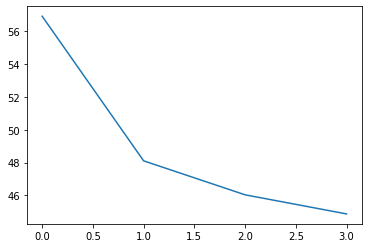

In [7]:
#print(f"loss at epoch 1: {history['loss'][0]}")
#print(f"loss at epoch 5: {history['loss'][2]}")
#print(f"loss at epoch 10: {history['loss'][3]}")
plt.plot(history['loss'])

In [8]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 128
n_values = len(vocab)+1 # number of words and the blank space
Tx = 30 # max len of sequences
reshaper = Reshape((1, n_values))                  # Used in Step 2.B of model(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

## Treat inputs

In [9]:
def sentences_to_indices(X, word_to_ix, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros( (m, max_len) )
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        # We truncate sentence_words at max_len
        sentence_words = sentence_words[:max_len]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_ix:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_ix[w]
                # Increment j to j + 1
                j += 1
            
    ### END CODE HERE ###
    
    return X_indices

def convert_to_one_hot(X_indices, C):
    """
    Arguments:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    C -- size of one-hot vectors -1 place for 1 word in vocabulary, plus blank space-
    
    Returns:
    X_oh -- array of one-hot vectors corresponding to words in the sentences from X, of shape (m, max_len, C)
    """
    X_oh = np.eye(C)[X_indices]
    return X_oh

## Predictions over the validation set

In [10]:
len(sentences_test)

4528

In [11]:
sentences_test[:20]

['Put the clips part  part and part of the loom knoop hardness test value   channel B part  the loom HB2   channel B part and the No 2 starboard igniter lead part with the bolt part and the spacers part and part in position on the oil tube part and loosely install the nut part  <eos>',
 'Put the clips part  part  part and part of the air tube part  the fuel tube part  the fuel tube part and the loom database part with the spacers part  part and part and the bolt part in position on the nut part attached to the bracket part  and loosely install the bolt part  <eos>',
 'Make sure that the ignition lever part of the door damper part and the emergency opening actuator part is in the ARMED position  <eos>',
 'You can use these pressurization sources as an alternative  or   <eos>',
 'Disconnect the electrical connectors from the 115VAC EPDC2 temporary revision 1422XZ and the 230VAC EPDC2 temporary revision 1424XZ in module 2H   <eos>',
 'Alodine 1500 mil <unk> <unk> <eos>',
 'The transducer 

In [12]:
# Choose sentence to predict, from validation set
n = 16
sentences_test[n]

'It is possible to restore the avionics server function cabinet with the group 1 and amperes per square foot software components    only and then dispatch the aircraft under Master Minimum Equipment List MMEL condition <eos>'

In [13]:
# Build vectors needed to predict
a0 = np.zeros((1, n_a))
c0 = np.zeros((1, n_a))
X_oh = np.zeros((1, Tx, len(vocab)+1))
x_indices = sentences_to_indices(np.asarray(sentences_test[n:n+1]), word_to_ix, Tx)
X_oh[0,:,:] = convert_to_one_hot(x_indices.astype(int), C = len(vocab)+1)

# Build and print expected prediction (y_true value)
y_indices = np.zeros(np.shape(x_indices))
y_indices[:,0:Tx-1] = x_indices[:,1:Tx]
print(y_indices, '\n', ' '.join(sentences_test[n:n+1][0].lower().split()[1:]) )

[[3884. 5265. 6697. 5670. 6627. 1402. 5986. 3287. 1714. 7140. 6627. 3453.
    62. 1245. 1236. 5105. 6267. 3140. 6174. 2037. 4866. 1245. 6631. 2525.
  6627. 1171. 6871. 4495. 4587.    0.]] 
 is possible to restore the avionics server function cabinet with the group 1 and amperes per square foot software components only and then dispatch the aircraft under master minimum equipment list mmel condition <eos>


In [14]:
# Obtain prediction
pred = reconstructed_model.predict([X_oh, a0, c0])
pred_indices = np.argmax(pred, axis=-1)

# Build annd print sentence from prediction
sample_sentence_words = [ix_to_word[int(index)] for index in list(pred_indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]

print(pred_indices.T, '\n', sample_sentence)

[[3884 4725 6697 6627 6627 1275 2022 3287 1714  991 6627 6174  991  991
  6627  991 6724 6950  991 2036 6625  991 6627 1301 3884 1171 3884 6627
   991  991]] 
 Is necessary to the the applicable compartment function cabinet <eos> the software <eos> <eos> the <eos> torque value <eos> component that <eos> the are is aircraft is the <eos> <eos>


## Sampling Model 1: does not use probability

We first define a model that uses each step prediction as the input for next step

In [15]:
def sentence_inference_model1(LSTM_cell, densor, Ty=30):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
        outputs.append(out)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=-1)
        x = tf.one_hot(x,n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, n_values)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model1 = Model(inputs=[x0,a0,c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model1

In [16]:
inference_model1 = sentence_inference_model1(LSTM_cell, densor, Ty = 30)

In [17]:
# Useful commands for transfer learning
#reconstructed_model.layers[6]
#LSTM_cell.set_weights(reconstructed_model.layers[6].get_weights())
#densor.set_weights(reconstructed_model.layers[-1].get_weights())
#inference_model1.load_weights("trained_weights")

In [18]:
inference_model1.set_weights(reconstructed_model.get_weights())

We use previous model to sample ('predict') a sequence

In [19]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [20]:
def predict_and_sample1(inference_model1, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model1.predict([x_initializer, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=-1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=x_initializer.shape[2])
    ### END CODE HERE ###
    
    return results, indices

In [317]:
results, indices = predict_and_sample1(inference_model1, x_initializer, a_initializer, c_initializer)

#print("np.argmax(results[12]) =", np.argmax(results[0]))
#print("np.argmax(results[17]) =", np.argmax(results[17]))
#print("list(indices[12:18]) =", list(indices[12:18]))

# Transform the result to an actual sentence
sample_sentence_words = [ix_to_word[int(index)] for index in list(indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]
print(sample_sentence)

The applicable access panels and the door part <eos>                     


## Sampling Model 2: choose at random

We first define a model that uses each step prediction as the input for next step

In [238]:
def sentence_inference_model2(LSTM_cell, densor, Ty=30):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        outputs.append(out)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        
        x = tf.math.argmax(out,axis=-1)        
        x = tf.one_hot(x,n_values)
        
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, n_values)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model2 = Model(inputs=[x0,a0,c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model2

In [239]:
inference_model2 = sentence_inference_model2(LSTM_cell, densor, Ty = 30)
inference_model2.set_weights(reconstructed_model.get_weights())

We use previous model to sample ('predict') a sequence

In [240]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [241]:
def predict_and_sample2(inference_model2, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model2.predict([x_initializer, a_initializer, c_initializer])
    Ty = np.shape(pred)[0]
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.zeros((Ty,1))
    for t in range(Ty):
        distr = pred[t][0][:]
        indices[t,0] = np.random.choice( range(n_values), p=distr)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=x_initializer.shape[2])
    ### END CODE HERE ###
    
    return results, indices

In [321]:
results, indices = predict_and_sample2(inference_model2, x_initializer, a_initializer, c_initializer)

# Transform the result to an actual sentence
sample_sentence_words = [ix_to_word[int(index)] for index in list(indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]
print(sample_sentence)

Tracks applicable seat door and key floor of tightly                     


## Sampling Model 3: choose at random at each step

We first define a model that uses each step prediction as the input for next step

In [222]:
def sentence_inference_model3(LSTM_cell, densor, Ty=30):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    output_indices = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        distr = densor(a)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        
        x = tf.random.categorical(distr,1)
        x = tf.squeeze(x, axis=-1)
        #x = K.print_tensor(x, message='x = ')
        output_indices.append(x)
        
        x = tf.one_hot(x,n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, n_values)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model3 = Model(inputs=[x0,a0,c0], outputs=output_indices)
    
    ### END CODE HERE ###
    
    return inference_model3

In [223]:
inference_model3 = sentence_inference_model3(LSTM_cell, densor, Ty = 30)
inference_model3.set_weights(reconstructed_model.get_weights())

We use previous model to sample ('predict') a sequence

In [224]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [225]:
def predict_and_sample3(inference_model3, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    predicted_output_indices = inference_model3.predict([x_initializer, a_initializer, c_initializer])
    # Step 2: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(predicted_output_indices, num_classes=x_initializer.shape[2])
    ### END CODE HERE ###
    
    return results, predicted_output_indices

In [234]:
results, predicted_output_indices = predict_and_sample3(inference_model3, x_initializer, a_initializer, c_initializer)

# Transform the result to an actual sentence
sample_sentence_words = [ix_to_word[int(index)] for index in list(predicted_output_indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]
print(sample_sentence)

10 g04 2xze98 j39 211vm sides 69 gone future limitations manifest cleaner centerline spotlight inhibited beams grit resinae 3043vc fixture ip2 hammer responder customer barrel flare 4011wd2 indicator 5a 5900we


## Sampling Model 4: provide 1st word

We first define a model that uses each step prediction as the input for next step

In [243]:
def sentence_inference_model4(LSTM_cell, densor, Ty=30):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    x1 = Input(shape=(n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Force first word to the one given
        if t == 0:
            out = tf.cast(x1, tf.int32)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
        outputs.append(out)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=-1)
        x = tf.one_hot(x,n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, n_values)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model4 = Model(inputs=[x0,x1,a0,c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model4

In [244]:
inference_model4 = sentence_inference_model4(LSTM_cell, densor, Ty = 30)

We use previous model to sample ('predict') a sequence

In [247]:
x_initializer = np.zeros((1, 1, n_values))
x1 = np.zeros((1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [248]:
def predict_and_sample4(inference_model4, x_initializer = x_initializer, x1 = x1, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model4.predict([x_initializer, x1, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=-1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=x_initializer.shape[2])
    ### END CODE HERE ###
    
    return results, indices

In [324]:
x_initializer = np.zeros((1, 1, n_values))

# Force first word
init = np.zeros((1, n_values))
init[0,word_to_ix['if']] = 1
x1 = init

a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [333]:
x_initializer = np.zeros((1, 1, n_values))

# Take first word at random
init = np.zeros((1, n_values))
random_word_index = np.random.choice(np.arange(n_values), p=first_word_freq)
print(random_word_index, ix_to_word[random_word_index])

init[0,random_word_index] = 1
x1 = init

a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

1366 attach


In [335]:
results, indices = predict_and_sample4(inference_model4, x_initializer, x1, a_initializer, c_initializer)

#print("np.argmax(results[12]) =", np.argmax(results[0]))
#print("np.argmax(results[17]) =", np.argmax(results[17]))
#print("list(indices[12:18]) =", list(indices[12:18]))

# Transform the result to an actual sentence
sample_sentence_words = [ix_to_word[int(index)] for index in list(indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]
print(sample_sentence)

Attach the electrical connector part to the related electrical connector part <eos>                  


## Sampling Model 5: provide words

We first define a model that uses each step prediction as the input for next step

In [308]:
def sentence_inference_model5(LSTM_cell, densor, Ty=30):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    x1 = Input(shape=(2, n_values))
    given_words = np.zeros((2, n_values))
    #for t in range(1):
    #    given_words[t] = x1[t,:]
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Force first word to the one given
        if t <= 1:
            out = tf.cast(x1[t,:], tf.int32)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values) (≈1 line)
        outputs.append(out)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=-1)
        x = tf.one_hot(x,n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, n_values)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model5 = Model(inputs=[x0,x1,a0,c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model5

In [309]:
inference_model5 = sentence_inference_model5(LSTM_cell, densor, Ty = 30)

We use previous model to sample ('predict') a sequence

In [287]:
x_initializer = np.zeros((1, 1, n_values))
x1 = np.zeros((1, 2, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [312]:
def predict_and_sample5(inference_model5, x_initializer = x_initializer, x1 = x1, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, n_values), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model5.predict([x_initializer, x1, a_initializer, c_initializer])
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=-1)
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=x_initializer.shape[2])
    ### END CODE HERE ###
    
    return results, indices

In [310]:
x_initializer = np.zeros((1, 1, n_values))

# Force first word
init = np.zeros((1, 2, n_values))
init[0,0,word_to_ix['if']] = 1
init[0,1,word_to_ix['there']] = 1
x1 = init

a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [313]:
results, indices = predict_and_sample5(inference_model5, x_initializer, x1, a_initializer, c_initializer)

#print("np.argmax(results[12]) =", np.argmax(results[0]))
#print("np.argmax(results[17]) =", np.argmax(results[17]))
#print("list(indices[12:18]) =", list(indices[12:18]))

# Transform the result to an actual sentence
sample_sentence_words = [ix_to_word[int(index)] for index in list(indices)]
sample_sentence = ' '.join(sample_sentence_words)
sample_sentence = sample_sentence[0].upper() + sample_sentence[1:]
print(sample_sentence)

InvalidArgumentError: Graph execution error:

Detected at node 'model_24/tf.__operators__.getitem_249/strided_slice' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 534, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1771, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
      ret = callback()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
      self.run()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
      user_expressions, allow_stdin,
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-313-416b38e84fd0>", line 1, in <module>
      results, indices = predict_and_sample5(inference_model5, x_initializer, x1, a_initializer, c_initializer)
    File "<ipython-input-312-f0ca37dd0bfa>", line 21, in predict_and_sample5
      pred = inference_model5.predict([x_initializer, x1, a_initializer, c_initializer])
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
      return self(x, training=False)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\core\tf_op_layer.py", line 503, in _call_wrapper
      return original_call(*new_args, **new_kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\core\tf_op_layer.py", line 226, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\core\tf_op_layer.py", line 261, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model_24/tf.__operators__.getitem_249/strided_slice'
slice index 1 of dimension 0 out of bounds.
	 [[{{node model_24/tf.__operators__.getitem_249/strided_slice}}]] [Op:__inference_predict_function_703904]